In [2]:
import pandas as pd 
import numpy as np
from pandas_datareader import data as pdr

import yfinance as yf #yahoo finance stock data
import datetime
import matplotlib
import matplotlib.pyplot as plt
from math import sqrt

import tensorflow as tf
from tensorflow import keras

from sklearn.linear_model import LinearRegression,ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.tree import export_graphviz
from sklearn import tree

from keras.models import Sequential
from keras.layers import Activation,Dropout,Dense,LSTM,BatchNormalization

stock="^GSPC"

In [20]:
#min=yf.download(tickers=stock,period="3d",interval="1m")
#thirt_min=yf.download(tickers=stock,period="60d", interval="30m")
#hour=yf.download(tickers=stock,period="150d",interval="1h")
#daily=yf.download(tickers=stock,period="1000d",interval="1d")
#weekly=yf.download(tickers=stock,period="3800d",interval="1wk")

min_=pd.read_csv(f'..\Data\Prices\{stock}_min.csv',index_col=0)
thirt_min=pd.read_csv(f'..\Data\Prices\{stock}_thirt_min.csv',index_col=0)
hour=pd.read_csv(f'..\Data\Prices\{stock}_hour.csv',index_col=0)
daily=pd.read_csv(f'..\Data\Prices\{stock}_daily.csv',index_col=0)
weekly=pd.read_csv(f'..\Data\Prices\{stock}_weekly.csv',index_col=0)

In [21]:
def Prepare_dataset(df,data_size=255,forecast_window=1):
    from sklearn.model_selection import train_test_split

    df.dropna(inplace=True,how="all",axis=0)
    df.fillna(inplace=True,method="ffill")
    df=df.iloc[-data_size:]
    y=df.shift(-forecast_window).iloc[:-forecast_window,3].values
    X=df.drop("Adj Close",1)
    X=X.iloc[:-forecast_window,:]
    return train_test_split(X, y, test_size=0.2, random_state=0,shuffle=False)

def Mape(y,y_pred):
    mape=np.mean(np.abs((y-y_pred)/y))
    return "{:.2%}".format(mape)

def Rmse(y,y_pred):
    return np.sqrt(((y_pred - y) ** 2).mean())

def normalize(data):
    data_mean = data.mean(axis=0)
    data_std = data.std(axis=0)
    return (data - data_mean) / data_std


def Arima_build(ts_train,ts_test):
  global arima_model
  def arimamodel(timeseriesarray):
    import pmdarima as pmd
    autoarima_model = pmd.auto_arima(timeseriesarray, 
                              start_p=1,d=1,start_q=0, start_P=0,D=1, start_Q=0,
                              max_p=5,max_d=5,max_q=5, max_P=5,max_D=5,max_Q=5, 
                              m=12, seasonal=True,error_action='warn',trace=True,
                              supress_warnings=True,stepwise=True,
                              random_state=123,n_fits=10)
    return autoarima_model

  arima_model = arimamodel(ts_train)
  preds=arima_model.predict(len(ts_test))
  return preds

def plot_history(history):
    hist=pd.DataFrame(history.history)
    hist["epoch"]=history.epoch

    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Mean Abs Error")
    plt.plot(hist.epoch,hist.mae,label="Train error")
    plt.plot(hist.epoch,hist.val_mae,label="Val error")
    plt.legend()
    plt.ylim([0,hist.mae.max()])

def Build_lstm(X_train,X_test,y_train,scale=True):
    keras.backend.clear_session()
    tf.compat.v1.reset_default_graph() 

    global lstm_model

    if scale==True:     
        x_scaler = StandardScaler()
        X_train=x_scaler.fit_transform(X_train)
        X_test=x_scaler.transform(X_test)
        
    x_train=np.array(X_train).reshape(X_train.shape[0],X_train.shape[1],1)
    x_test=np.array(X_test).reshape(X_test.shape[0],X_test.shape[1],1)

    lstm_model = Sequential()
    lstm_model.add(LSTM(64,return_sequences=True))
    lstm_model.add(LSTM(128,return_sequences=False))
    lstm_model.add(Dense(units=32))
    lstm_model.add(Dense(units=1))


    lstm_model.compile(loss="mse",optimizer="nadam",metrics=['accuracy'])
    lstm_model.fit(x_train, np.array(y_train), epochs=1000,verbose=0,batch_size=32)
    preds=lstm_model.predict(x_test, batch_size=1)

    return preds



In [22]:
datasets={}
datasets["1m"]=Prepare_dataset(min_,forecast_window=1)
datasets["30m"]=Prepare_dataset(thirt_min,forecast_window=1)
datasets["1h"]=Prepare_dataset(hour,forecast_window=1)
datasets["D"]=Prepare_dataset(daily,forecast_window=1)
datasets["W"]=Prepare_dataset(weekly,forecast_window=1)

In [27]:
mape=pd.DataFrame(columns=["1m","30m","1h","D","W"])
rmse=pd.DataFrame(columns=["1m","30m","1h","D","W"])

arima_models={}
elastic_nets={}
rf_models={}
ltsm_models={}

preds={}

for key in datasets:
    X_train=datasets[key][0]
    X_test=datasets[key][1]
    y_train=datasets[key][2]
    y_test=datasets[key][3]

    elastic=ElasticNet().fit(X_train, y_train)
    elastic_preds=elastic.predict(X_test)
    mape.loc["Elastic net",key]=[Mape(y_test,elastic_preds)]
    rmse.loc["Elastic net",key]=[Rmse(y_test,elastic_preds)]
    elastic_nets[key]=elastic

    rf=RandomForestRegressor(n_estimators=100,max_depth=4,random_state=0).fit(X_train, y_train)
    rf_preds=rf.predict(X_test)
    mape.loc["Random forest",key]=[Mape(y_test,rf_preds)]
    rmse.loc["Random forest",key]=[Rmse(y_test,rf_preds)]
    rf_models[key]=rf

    arima_preds=Arima_build(datasets[key][0]["Close"],datasets[key][1]["Close"])
    mape.loc["ARIMA",key]=[Mape(y_test,arima_preds)]
    rmse.loc["ARIMA",key]=[Rmse(y_test,arima_preds)]
    arima_models[key]=arima_model

    lstm_preds=Build_lstm(X_train,X_test,y_train) 
    mape.loc["LSTM scaled",key]=[Mape(y_test,lstm_preds)]
    rmse.loc["LSTM scaled",key]=[Rmse(y_test,lstm_preds)]
    ltsm_models[key]=lstm_model

    preds[key]=[arima_preds,elastic_preds,rf_preds,lstm_preds]

    print(f"Model for {key} dataset is done")

Performing stepwise search to minimize aic
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=470.522, Time=0.03 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=469.896, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=420.452, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.47 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=387.352, Time=0.25 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=387.375, Time=0.43 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.95 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.84 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=3.94 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=388.091, Time=0.16 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=382.906, Time=0.37 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=416.789, Time=0.13 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=382.444, Time=0.65 sec
 ARIMA(2,1,0)(4,1,0)[12]             : AIC=379.718, Time=1.20 sec
 ARIMA(2,1,0)(5,1,0)[12]             : AIC=376.67

D:\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 249709.20474624902, tolerance: 1969.4012995844748
  model = cd_fast.enet_coordinate_descent(


Performing stepwise search to minimize aic
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=2246.407, Time=0.07 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2260.262, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2186.540, Time=0.21 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2154.392, Time=0.36 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=2251.506, Time=0.05 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=2155.856, Time=0.53 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=2155.670, Time=1.09 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=2193.339, Time=0.20 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=3.20 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=2164.323, Time=0.29 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=2143.991, Time=0.74 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=2242.893, Time=0.07 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=2144.727, Time=0.62 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=2144.331, Time=2.18 sec
 ARIMA(1,1,1)(1,1,0)[12]

D:\Python38\lib\site-packages\pmdarima\arima\_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(2,1,1)(3,1,2)[12]           (if you do not want to see these warnings, run with error_action="ignore").
  warnings.warn(warning_str, ModelFitWarning)


 ARIMA(2,1,1)(3,1,2)[12]             : AIC=inf, Time=nan sec
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=2143.753, Time=3.17 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=2136.340, Time=2.40 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=2136.845, Time=1.07 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=2143.706, Time=0.71 sec
 ARIMA(2,1,0)(3,1,1)[12]             : AIC=2138.297, Time=6.73 sec
 ARIMA(2,1,0)(2,1,2)[12]             : AIC=inf, Time=4.02 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=2171.528, Time=0.25 sec
 ARIMA(2,1,0)(1,1,2)[12]             : AIC=inf, Time=2.82 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=2137.807, Time=1.53 sec
 ARIMA(2,1,0)(3,1,2)[12]             : AIC=inf, Time=7.86 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=2146.994, Time=2.10 sec
 ARIMA(3,1,0)(2,1,1)[12]             : AIC=2134.449, Time=1.87 sec
 ARIMA(3,1,0)(1,1,1)[12]             : AIC=2136.162, Time=0.67 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=2143.713, Time=0.80 sec
 ARIMA(3,1,0)(3,

D:\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 191557.99671838593, tolerance: 2207.8383010116713
  model = cd_fast.enet_coordinate_descent(


 ARIMA(1,1,0)(0,1,0)[12]             : AIC=2120.082, Time=0.04 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2119.979, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2081.082, Time=0.19 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.31 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=2069.743, Time=0.39 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=2059.388, Time=0.85 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=2054.530, Time=1.84 sec
 ARIMA(1,1,0)(5,1,0)[12]             : AIC=2044.961, Time=5.46 sec
 ARIMA(1,1,0)(5,1,1)[12]             : AIC=inf, Time=21.95 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=inf, Time=5.88 sec
 ARIMA(0,1,0)(5,1,0)[12]             : AIC=2044.562, Time=7.07 sec
 ARIMA(0,1,0)(4,1,0)[12]             : AIC=2054.395, Time=2.04 sec
 ARIMA(0,1,0)(5,1,1)[12]             : AIC=inf, Time=15.99 sec
 ARIMA(0,1,0)(4,1,1)[12]             : AIC=inf, Time=4.76 sec
 ARIMA(0,1,1)(5,1,0)[12]             : AIC=2044.894, Time=6.70 sec
 ARIMA(1,1,1)(5,1,

In [29]:
rmse

,1m,30m,1h,D,W
Elastic net,[2.3897474681580095],[6.220705076095396],[9.39306200956599],[42.26240192088808],[134.0055059110398]
Random forest,[4.788199121286089],[9.898648503839942],[55.76754385207274],[186.4411327778385],[260.94434257404026]
ARIMA,[5.5427010826425125],[49.53127070075931],[63.25696705004073],[63.37807187603306],[400.11325198259107]
LSTM scaled,[7.745566991304287],[10.790204702457311],[46.847811178031684],[185.63669427588485],[457.712975185957]


In [30]:
mape

,1m,30m,1h,D,W
Elastic net,[0.05%],[0.11%],[0.20%],[0.93%],[3.20%]
Random forest,[0.08%],[0.21%],[1.32%],[4.43%],[5.68%]
ARIMA,[0.10%],[1.12%],[1.45%],[1.44%],[10.86%]
LSTM scaled,[0.15%],[0.23%],[1.09%],[4.40%],[11.45%]


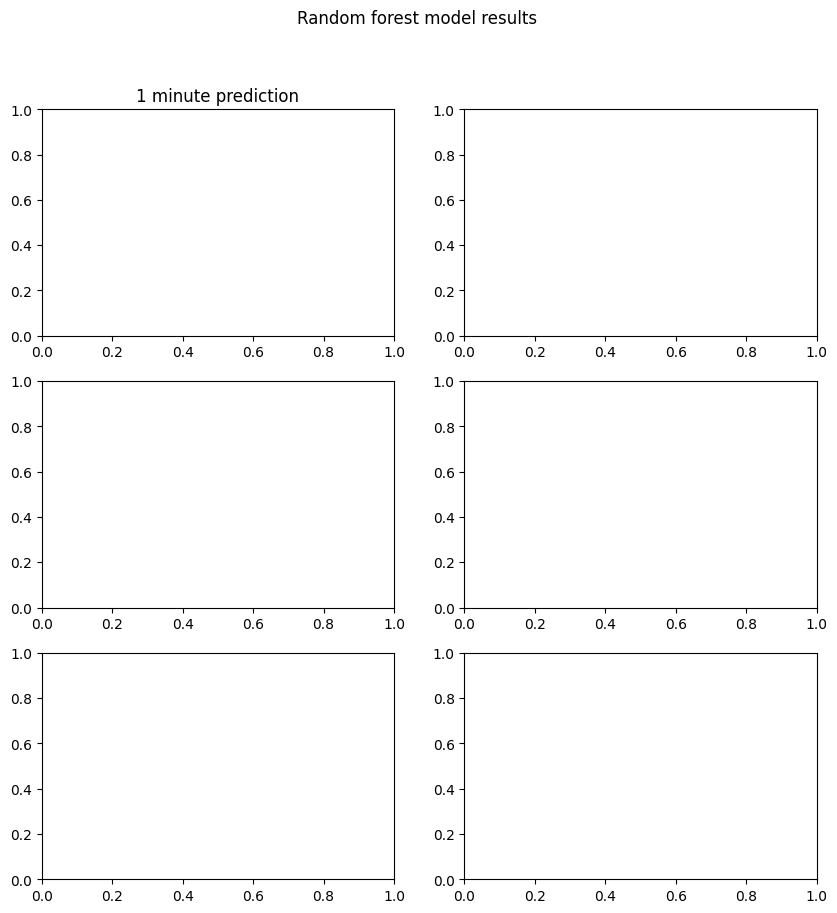

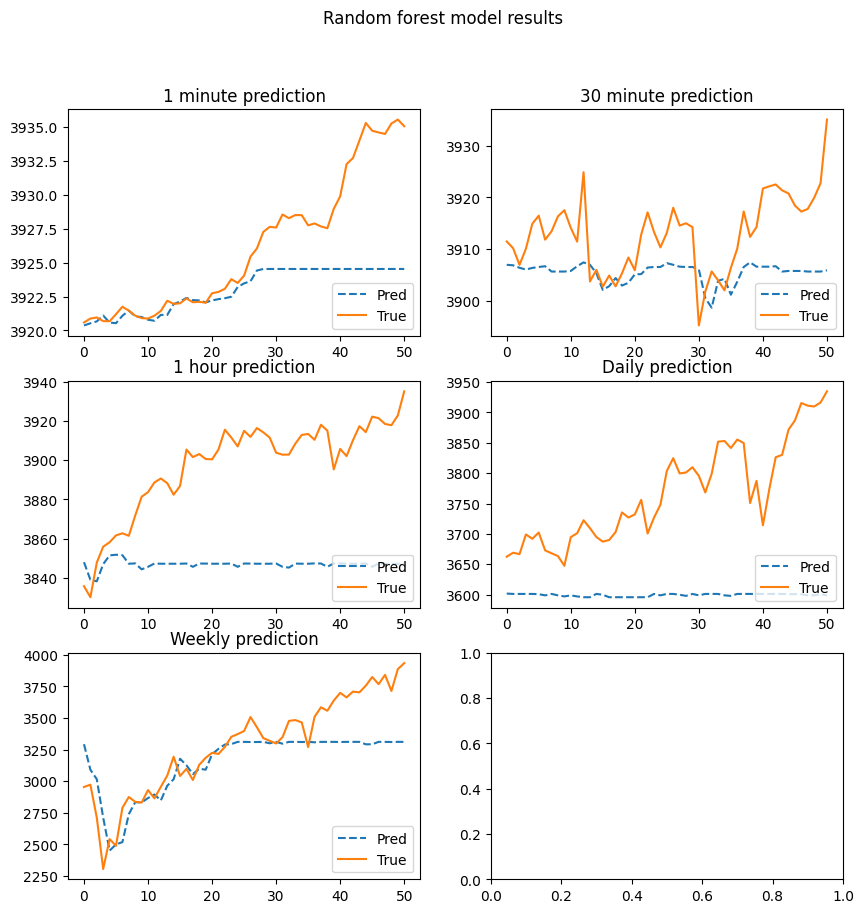

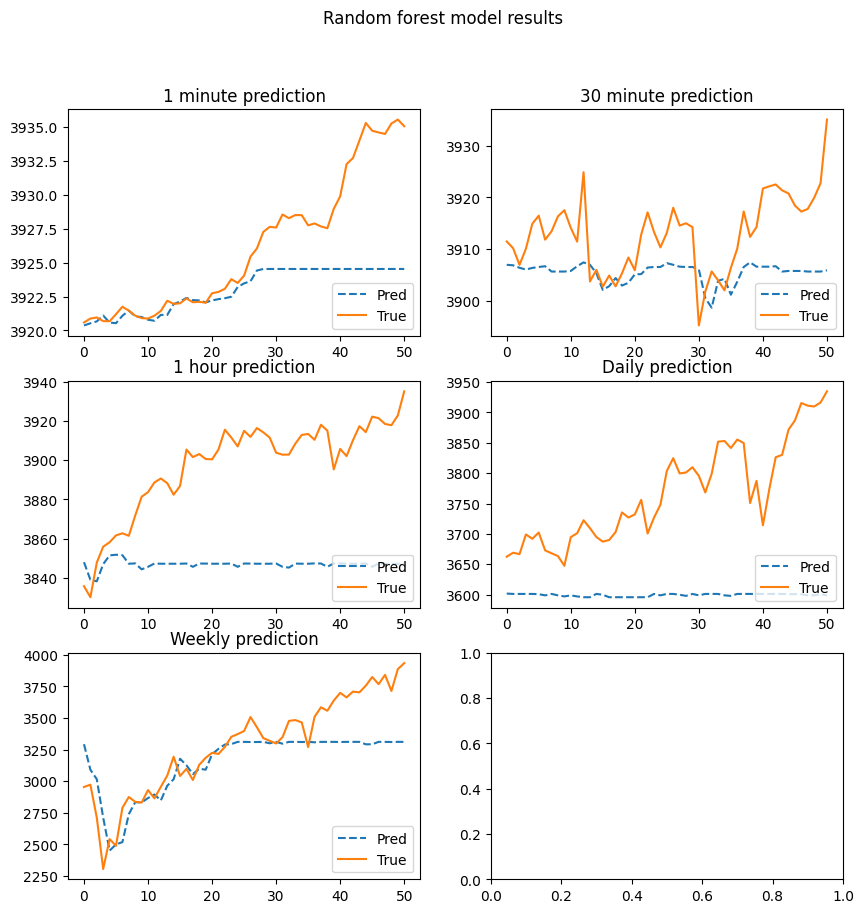

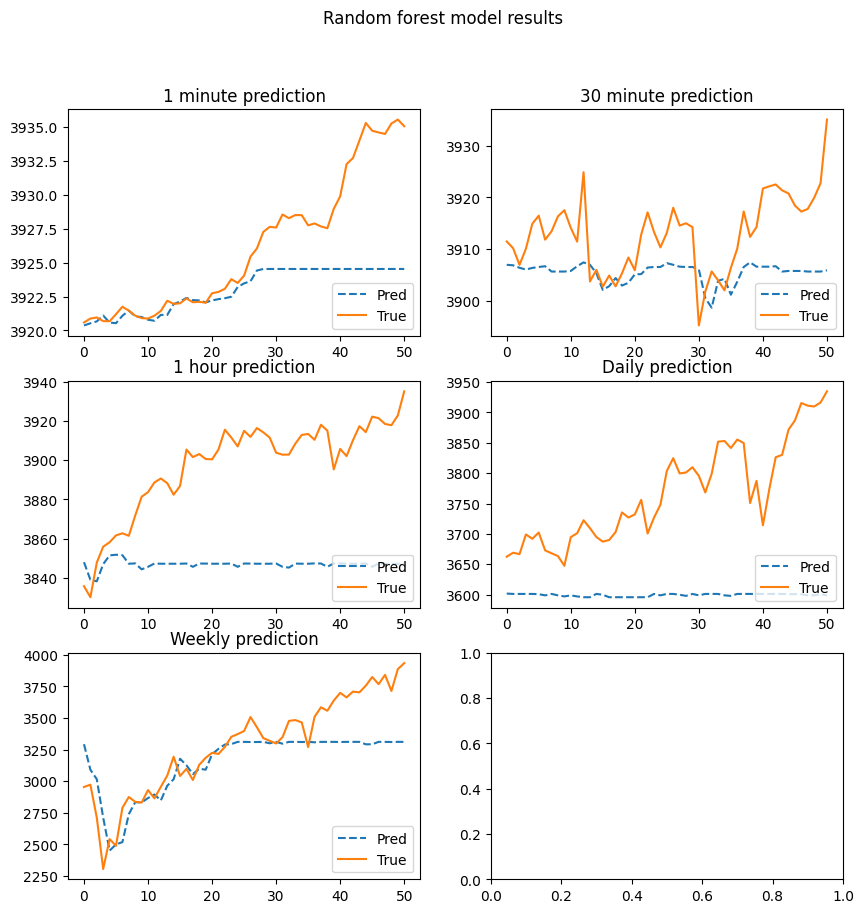

In [32]:
m=2

matplotlib.rcParams.update(matplotlib.rcParamsDefault)

fig, axs = plt.subplots(3, 2,figsize=(10,10))
fig.suptitle('Random forest model results')

axs[0, 0].set_title('1 minute prediction')
axs[0,0].plot(preds['1m'][m], linestyle='dashed',label="Pred")
axs[0,0].plot(datasets['1m'][3],label="True")
axs[0,0].legend(loc="lower right")

axs[0, 1].set_title('30 minute prediction')
axs[0,1].plot(preds['30m'][m], linestyle='dashed',label="Pred")
axs[0,1].plot(datasets['30m'][3],label="True")
axs[0,1].legend(loc="lower right")

axs[1, 0].set_title('1 hour prediction')
axs[1,0].plot(preds['1h'][m], linestyle='dashed',label="Pred")
axs[1,0].plot(datasets['1h'][3],label="True")
axs[1,0].legend(loc="lower right")

axs[1, 1].set_title('Daily prediction')
axs[1,1].plot(preds['D'][m], linestyle='dashed',label="Pred")
axs[1,1].plot(datasets['D'][3],label="True")
axs[1,1].legend(loc="lower right")

axs[2, 0].set_title('Weekly prediction')
axs[2,0].plot(preds['W'][m], linestyle='dashed',label="Pred")
axs[2,0].plot(datasets['W'][3],label="True")
axs[2,0].legend(loc="lower right")
plt.show()

In [33]:
arima_models

{'1m': ARIMA(order=(0, 1, 0), scoring_args={}, seasonal_order=(4, 1, 0, 12),
       suppress_warnings=True, with_intercept=False),
 '30m': ARIMA(order=(0, 1, 0), scoring_args={}, seasonal_order=(0, 1, 1, 12),
       suppress_warnings=True, with_intercept=False),
 '1h': ARIMA(order=(0, 1, 0), scoring_args={}, seasonal_order=(5, 1, 0, 12),
       suppress_warnings=True, with_intercept=False),
 'D': ARIMA(order=(1, 1, 0), scoring_args={}, seasonal_order=(5, 1, 1, 12),
       suppress_warnings=True, with_intercept=False),
 'W': ARIMA(order=(0, 1, 0), scoring_args={}, seasonal_order=(0, 1, 1, 12),
       suppress_warnings=True, with_intercept=False)}

In [ ]:
plot_preds(key):
    preds[key][0]

array([3673.38989258, 3672.91992188, 3673.86010742, 3674.12011719,
       3674.34008789, 3674.01000977, 3675.13989258, 3675.56005859,
       3675.42993164, 3675.51000977, 3675.67993164, 3675.12988281,
       3675.02001953, 3674.72998047, 3674.20996094, 3672.97998047,
       3671.92993164, 3670.95996094, 3671.25      , 3671.56005859,
       3672.57006836, 3671.72998047, 3672.51000977, 3672.79003906,
       3672.80004883, 3673.16992188, 3673.45996094, 3673.12988281,
       3672.91992188, 3672.26000977, 3672.39990234, 3671.20996094,
       3672.20996094, 3673.13989258, 3672.43994141, 3673.06005859,
       3673.11010742, 3672.64990234, 3673.04003906, 3672.75      ,
       3672.27001953, 3672.42993164, 3672.67993164, 3671.0300293 ,
       3670.05004883, 3670.48999023, 3670.23999023, 3670.47998047,
       3670.57006836, 3670.4699707 , 3669.94995117])

In [ ]:
arima_models["1m"],arima_models["30m"],arima_models["1h"],arima_models["D"],arima_models["W"]

(ARIMA(order=(0, 1, 0), scoring_args={}, seasonal_order=(0, 0, 0, 1)),
 ARIMA(order=(1, 1, 0), scoring_args={}, seasonal_order=(0, 0, 0, 1)),
 ARIMA(order=(0, 1, 1), scoring_args={}, seasonal_order=(0, 0, 0, 1)),
 ARIMA(order=(0, 1, 0), scoring_args={}, seasonal_order=(0, 0, 0, 1)),
 ARIMA(order=(1, 1, 3), scoring_args={}, seasonal_order=(0, 0, 0, 1)))

ValueError: Unrecognized location 'upper_center'. Valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center


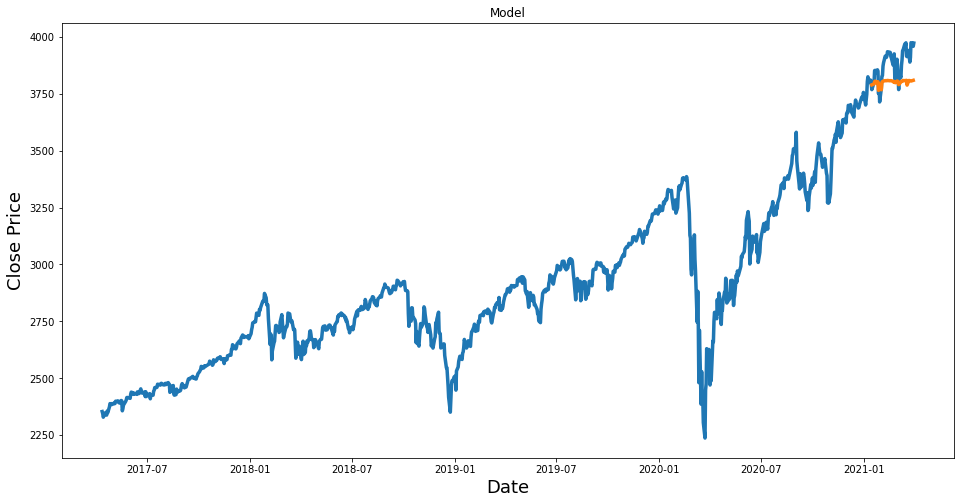

In [ ]:
#train = data[:training_data_len]
#valid = data[training_data_len:]
#valid['Predictions'] = predictions

plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price' ,fontsize=18)
plt.plot(daily['Close'],linewidth=3.5)
#plt.plot(datasets["W"][1].index,preds["W"][0],linewidth=3.5)
#plt.plot(datasets["W"][1].index,preds["W"][1],linewidth=3.5)
#plt.plot(datasets["W"][1].index,preds["W"][2],linewidth=3.5)
plt.plot(datasets["D"][1].index,preds["D"][3],linewidth=3.5)
plt.legend(['Train','Predictions'], loc='upper_center')